# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloBite.pkl") 
variables = open('./ModeloBite.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloBite.txt','r')
var_input = variables.read()

In [12]:
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist', 
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count','01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [15]:
corte

1.5563748356271413e-08

In [16]:
corte_01

9.922548639402257e-07

In [17]:
Y_c['pred_corte'] = Y_c['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,16708131,16142
1,13,582


In [18]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

In [58]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [59]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [60]:
testeo['target'].value_counts(dropna=False)

target
False    32966471
True          818
Name: count, dtype: int64

In [61]:
Y_target.shape

(32967289, 8)

In [62]:
#replace nan with 0
#testeo['01_sender_minutes_since_last_transaction_2days'] = testeo['01_sender_minutes_since_last_transaction_2days'].fillna(0)
#testeo['01_sender_days_to_last_transaction_365'] = testeo['01_sender_days_to_last_transaction_365'].fillna(0)
#testeo['01_sender_days_to_last_transaction_7m'] = testeo['01_sender_days_to_last_transaction_7m'].fillna(0)

In [63]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [64]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [65]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,32966455,16
1,309,509


In [66]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,32635747,330724
1,37,781


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

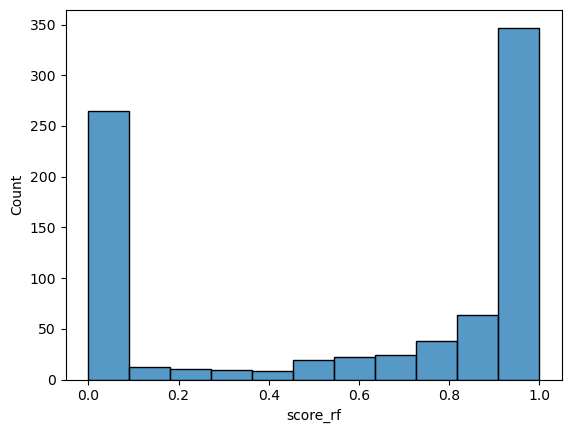

In [67]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [68]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9767726161369193


In [69]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,328892,781
2,329661,12
3,329667,6
4,329670,3
5,329670,3
...,...,...
96,329673,0
97,329673,0
98,329673,0


In [70]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.572659e-08  9.999999e-01
2             4.401725e-09  1.572657e-08
3             2.117275e-09  4.401724e-09
4             1.267751e-09  2.117275e-09
5             8.511047e-10  1.267751e-09
...                    ...           ...
96            2.869913e-13  3.402085e-13
97            2.334966e-13  2.869912e-13
98            1.780221e-13  2.334966e-13
99            1.166592e-13  1.780220e-13
100           2.629984e-15  1.166591e-13

[100 rows x 2 columns]

In [71]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [72]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [91]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,3551,78
2,3666,37
3,6566,24
4,2065,61
5,2068,45
6,2116,65
7,2175,30
8,2272,37
9,2464,26


In [99]:
pd.crosstab(tes_corte_01['date_receiver'].dt.year, Y_c_corte_01['targetF'])

targetF,False,True
date_receiver,,
2023,105799,442
2024,27225,32


In [74]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,7391,83
2,7445,37
3,11226,26
4,4201,61
5,4207,45
6,4243,66
7,4372,30
8,4551,37
9,4868,31


In [75]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,11203,84
2,11333,39
3,15730,26
4,6264,61
5,6340,45
6,6437,68
7,6575,30
8,6773,37
9,7357,33


In [76]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,15072,84
2,15229,39
3,20186,27
4,8331,61
5,8485,45
6,8638,68
7,8829,30
8,8995,37
9,9709,35


In [100]:
pd.crosstab(tes_corte_04['date_receiver'].dt.year, Y_c_corte_04['targetF'])

targetF,False,True
date_receiver,,
2023,105799,442
2024,27225,32


## Curva ROC y FP

In [77]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [78]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.902197184990086
ROC FRAUD TESTEO:
0.9723677969084819


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9508550710044725
Precision FRAUD TESTEO:
0.002355922233450476
Recall FRAUD TESTEO:
0.9547677261613692


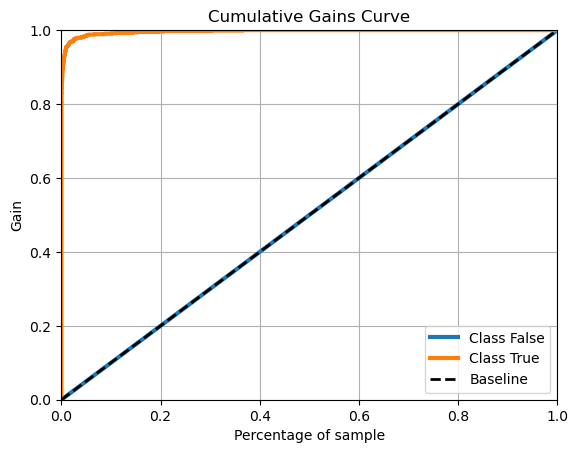

In [79]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


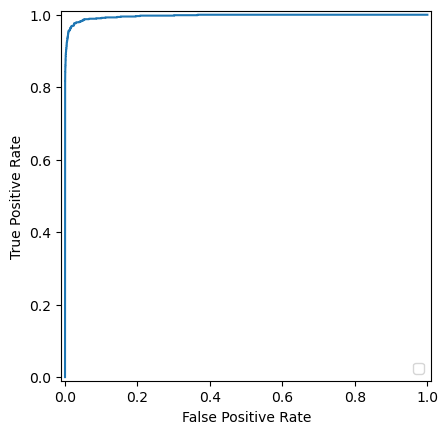

In [80]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

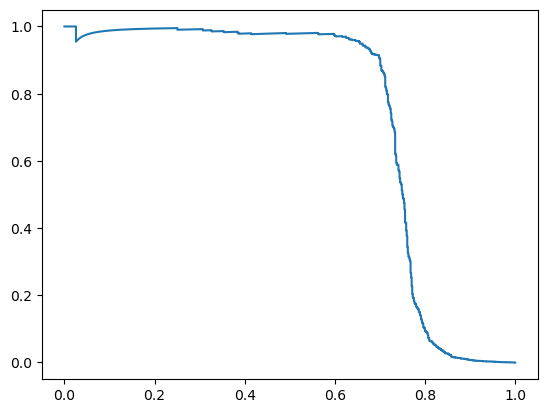

In [81]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [82]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

0.8002735978112175

## Monthly analysis

In [83]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,3732738,146
2,3887100,72
3,4381826,61
4,2116204,87
5,2289892,69
6,2193663,101
7,2314224,50
8,2296945,68
9,2420668,75


In [84]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,38616,143
2,39091,68
3,47380,53
4,20671,86
5,21331,69
6,21965,100
7,22354,50
8,22109,68
9,23849,66


In [85]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [86]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,38535,38934,39211,38573,38554,38390,38412,38244,38417,38184,38127,38131,38069,37729,38239,37767,37624,37871,38140,37872,37866,38180,37809,38183,37916,38310,37749,38313,37893,38397,38201,38161,38153,37787,38198,37607,37610,37906,37834,38092,37702,38165,38039,37861,38067,37807,37962,37866,38121,37996,37974,38001,37520,38283,37520,37688,37564,37133,37488,37509,37670,37390,37411,37540,37554,37386,37581,37274,37463,37191,37215,37309,37157,37243,36940,36887,36833,36786,36790,36512,36257,36496,36233,35979,35875,36002,35438,35697,35647,35411,35350,35129,35061,34578,34949,34923,34477,34100,34372,35324
2,38926,39807,39797,39675,39674,39822,39177,39452,39549,39349,39477,39397,39292,39215,39715,39260,39535,39334,39293,39108,39457,39174,39263,39284,39423,39187,39549,39261,39444,39341,38962,39311,39309,39332,38963,39206,39289,39163,39333,39326,39243,38938,38914,39091,39042,39104,38827,39235,39010,39016,38948,38902,39137,38576,39100,39095,38799,38911,38956,38944,38716,38589,38853,38767,38747,38818,38504,38371,38288,38586,38688,38676,38581,38468,38601,38469,38244,38732,38516,38428,38113,38637,38388,38338,38319,38303,38183,37947,38197,38057,38136,37930,37498,37568,37759,37484,37692,37692,38276,38794
3,47177,45389,45555,45663,45732,44962,45458,45204,45341,44884,45046,44918,45201,44534,44773,44838,44948,44891,44444,44814,44281,44570,44868,44567,44563,44280,44501,44303,44465,44427,44055,44146,43915,44187,44571,44290,44315,44348,44167,44124,44126,44004,43895,43830,44096,44004,43684,43733,43810,44028,43851,44456,43887,43545,43493,43564,43346,43640,43565,43543,43477,43542,43335,43515,43313,42801,43455,43463,43216,43162,43468,42949,42965,42948,43260,43165,43012,42800,43005,43008,43232,42910,42864,42874,43073,42966,43016,42987,42894,42686,42671,42609,42491,43040,42249,41904,42072,42031,41778,40866
4,20657,20323,20077,20088,20209,20277,20343,20437,20480,20387,20357,20346,20439,20721,20673,20499,20718,20600,20641,20761,20587,20719,20516,20440,20681,20858,20610,20856,20750,20512,20795,20714,20839,20888,20955,20837,20903,21104,20624,20719,20701,20710,21087,20926,21153,21103,21155,21175,21060,20687,20984,20910,21025,20825,21008,21224,21242,21194,21220,21000,21503,21189,21036,21071,20961,21188,21322,21389,21375,21444,21462,21398,21355,21513,21590,21607,21627,21697,21647,21686,21998,21809,22052,21963,22092,21905,22132,21968,22014,22050,22234,22315,22077,22250,22291,22635,22702,22723,22354,22338
5,21269,21784,21969,22254,22233,22490,22544,22268,22296,22635,22561,22390,22580,22400,22332,22797,22720,22668,22579,22581,22524,22663,22561,22479,22430,22555,22751,22676,22745,22511,22591,22474,22679,22807,22572,22880,23010,22620,22678,22645,22610,22871,22668,22781,22720,22957,22805,22923,22704,22992,22784,22608,22838,22785,23051,22883,23155,22945,23092,22706,22832,23056,23086,22871,23101,23103,23008,22942,22782,22801,23166,23101,23099,22878,23172,23273,23189,23177,23048,23376,23187,23318,23425,23246,23281,23585,23288,23504,23750,23559,23671,23668,23839,23718,23798,23481,23804,24011,23769,23919
6,21937,23185,22962,23163,23349,23071,23124,23230,22980,23010,22763,23264,22869,22986,22644,22712,22425,22587,22716,22803,22610,22604,22415,22458,22459,22618,22432,22380,22286,22283,22352,22159,22404,22305,22155,22368,22109,22081,21951,22046,22108,22249,22171,22045,21847,22043,21921,21760,22111,21862,21971,21836,21804,21720,21797,21756,21940,22052,21933,21532,21623,21544,21836,21494,21616,21594,21514,21769,21470,21640,21488,21663,21421,21427,21539,21259,21387,21518,21468,21276,21564,21358,21156,21363,21263,21389,21296,21139,20859,21070,21131,20864,20973,21159,20763,20752,206

In [87]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,4,5,6,7,9,11,12,15,16,20,21,31,37
mes,,,,,,,,,,,,,,,,
1,143,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
2,68,2,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,53,5,2,0,0,0,0,0,0,0,0,0,0,0,0,1
4,86,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,66,1,2,1,1,0,1,0,0,0,1,0,1,0,1,0


In [88]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
99521,1,Real,1
136425,2,Distraction,1
166402,3,Distraction,1
180042,6,Real,1
187184,1,Distraction,1
...,...,...,...
31918511,3,Real,3
32220826,3,Real,2
32669531,3,Real,3
32748885,3,Real,2


# Monthly indicators

In [98]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        if not subset_mes.empty:
            precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
            recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
            summary_metrics.loc[i,'month'] = m
            summary_metrics.loc[i,'year'] = y
            summary_metrics.loc[i,'precision'] = precision
            summary_metrics.loc[i,'recall'] = recall
            summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_02'].sum()
            summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
            summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_02']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
            #print ('Year:', y, 'Month:',m)
            #print ('Precision:', precision, 'Recall:',recall)
            i = i+1
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.017619,0.96875,3519,118,64,62
0,2,2023,0.008995,1.0,3780,58,34,34
5,3,2023,0.004842,0.954545,4337,44,22,21
1,4,2023,0.014313,1.0,4262,87,61,61
2,5,2023,0.010583,1.0,4252,69,45,45
3,6,2023,0.015317,0.942857,4309,101,70,66
4,7,2023,0.006815,1.0,4402,50,30,30
7,8,2023,0.008065,1.0,4588,68,37,37
8,9,2023,0.006328,0.704545,4899,75,44,31
9,10,2023,0.004818,0.75,4981,46,32,24


In [97]:
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.035247,0.96875,1759,118,64,62
0,2,2023,0.018124,1.0,1876,58,34,34
5,3,2023,0.009745,0.954545,2155,44,22,21
1,4,2023,0.028692,1.0,2126,87,61,61
2,5,2023,0.021297,1.0,2113,69,45,45
3,6,2023,0.029803,0.928571,2181,101,70,65
4,7,2023,0.013605,1.0,2205,50,30,30
7,8,2023,0.016024,1.0,2309,68,37,37
8,9,2023,0.010442,0.590909,2490,75,44,26
9,10,2023,0.008357,0.65625,2513,46,32,21


In [ ]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [ ]:
tes_corte_01['date_receiver'].dt.floor('d')

In [ ]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
#ALERTAS_01.to_csv ('./alertas.csv')

In [ ]:
ALERTAS_01

In [ ]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
#FRAUDES.to_csv ('./fraudes.csv')

In [ ]:
FRAUDES